In [2]:
%%html
<style>
table {float:left}
</style>

# Tick Predict

The aim of this project is to explore the predictive power of ARIMA models (AutoRegressive Integrated Moving Average) when applied to historic stock price data. This is a common application of predictive machine learning algorithms, since a model able to outperform the market in forecasting future stock price movements would offer potentially lucrative rewards.

The analysis below uses stock price data exported from the [Yahoo! Finance](https://finance.yahoo.com/) website.

In [91]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [4]:
palette = {
    "dark": "#252b33", "grey": "#45464d", "light": "#fefeff", 
    "stone": "#8f8f94", "blue": "#336681", "green": "#089389", 
    "red": "#d34748", "pink": "#cf82d3", "yellow": "#e6daaa"
}

In [246]:
def format_plot(fig):
    """
    Applies theme to Plotly figure.
    """
    fig.update_layout(
        plot_bgcolor=palette["dark"], paper_bgcolor=palette["dark"],
        title_font_color=palette["light"],
        xaxis_title_font_color=palette["light"], yaxis_title_font_color=palette["light"],
        xaxis_tickfont_color=palette["stone"], yaxis_tickfont_color=palette["stone"],
        xaxis_gridcolor=palette["grey"], yaxis_gridcolor=palette["grey"],
        xaxis_linecolor=palette["light"], yaxis_linecolor=palette["light"],
        title={"x": 0.5},  # Center title
        xaxis={"categoryorder": "category ascending"},  # Set y-axis labels from low to high
        yaxis={
            "categoryorder": "category ascending",  # Set y-axis labels from low to high
            # Add invisible y-ticks to add space between y-axis and y-labels
            "ticks": "outside", "tickcolor": palette["dark"], "ticklen": 5, 
        },
        legend_font_color=palette["stone"],
        margin=dict(l=80, r=20, t=40, b=20)
    )
    fig.update_yaxes(
        title_standoff = 5
    )

## GSK - UK FTSE 100 stock

First we will use a dataset for [GlaxoSmithKline](https://finance.yahoo.com/quote/GSK.L?p=GSK.L&.tsrc=fin-srch) (GSK), a major pharmaceutical company listed on the London Stock Exchange (LSE) and a component of the FTSE 100.

In [6]:
gsk_df = pd.read_csv("./data/20240124_GSK.L_5y.csv")

In [7]:
gsk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 0 to 1260
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1261 non-null   object 
 1   Open       1260 non-null   float64
 2   High       1260 non-null   float64
 3   Low        1260 non-null   float64
 4   Close      1260 non-null   float64
 5   Adj Close  1260 non-null   float64
 6   Volume     1260 non-null   float64
dtypes: float64(6), object(1)
memory usage: 69.1+ KB


In [8]:
gsk_df.shape

(1261, 7)

In [9]:
gsk_df.iloc[[0, -1]]

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-24,1486.859985,1490.687866,1466.914307,1470.339355,1107.309937,11112364.0
1260,2024-01-23,1554.800049,1558.599976,1536.599976,1554.199951,1554.199951,11751890.0


In [10]:
gsk_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1.260000e+03
mean,1524.322118,1540.476047,1510.044063,1524.547179,1344.735241,9.205261e+06
std,144.324186,149.331941,143.448492,144.798232,133.800329,4.994332e+06
min,1209.836548,1224.333496,1199.561523,1199.561523,1045.531250,1.976760e+05
25%,1408.350006,1423.599457,1393.729766,1409.019043,1249.905182,6.067516e+06
50%,1503.884338,1520.404968,1487.332153,1503.985046,1344.145813,7.765082e+06
75%,1648.238708,1664.658600,1632.725342,1648.843079,1418.824493,1.096694e+07
max,1859.380859,2746.587891,1841.651367,1859.582275,1708.324951,4.539564e+07


The dataset contains the five-year stock price history for GSK on the London Stock Exchange (LSE), from 24 January 2019 to 23 January 2024.

There are 1,261 entries, including one null entry dated 24 April 2023.

In [11]:
gsk_df[gsk_df.isnull().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume
1071,2023-04-24,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
gsk_df = gsk_df.dropna()

In [13]:
gsk_df.shape

(1260, 7)

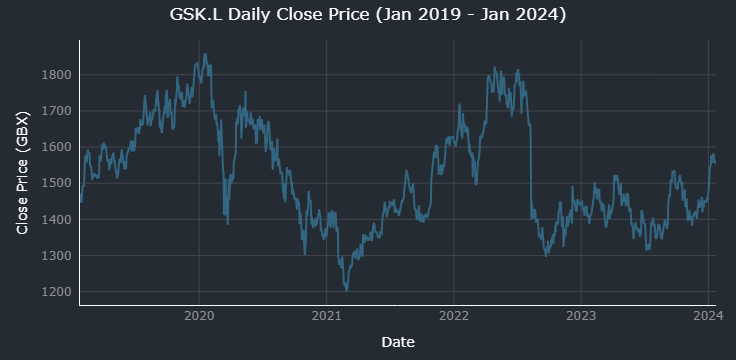

In [250]:
fig = go.Figure()
# Plot close prices
fig.add_trace(go.Scatter(x=gsk_df["Date"], y=gsk_df["Close"], mode="lines", name="Close Price (GBX)"))
# Update layout
fig.update_layout(title="GSK.L Daily Close Price (Jan 2019 - Jan 2024)",
                  xaxis_title="Date",
                  yaxis_title="Close Price (GBX)"
)
# Set label formats for hovering on data points
fig.update_traces(
    hovertemplate="%{x:%Y/%M/%D}<br>GBX: %{y:,.2f}<extra></extra>",  # extra code removes trace name default
    line_color=palette["blue"]
)
# Show plot
format_plot(fig)
fig.show()

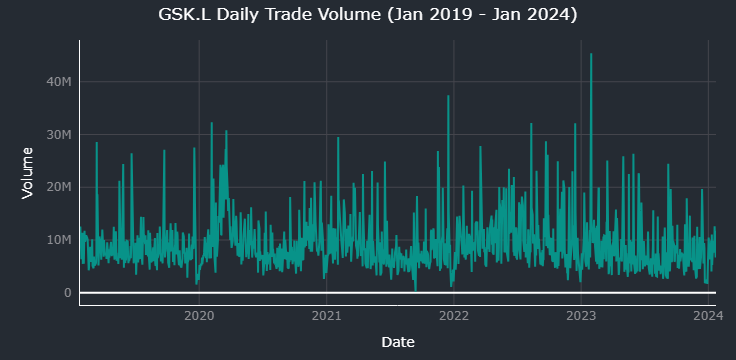

In [249]:
fig = go.Figure()
# Plot close prices
fig.add_trace(go.Scatter(x=gsk_df["Date"], y=gsk_df["Volume"], mode="lines", name="Volume"))
# Update layout
fig.update_layout(title="GSK.L Daily Trade Volume (Jan 2019 - Jan 2024)",
                  xaxis_title="Date",
                  yaxis_title="Volume"
)
# Set label formats for hovering on data points
fig.update_traces(
    hovertemplate="%{x:%Y/%M/%D}<br>%{y:,}<extra></extra>",  # <extra> code removes trace name default
    line_color=palette["green"]
)
# Show plot
format_plot(fig)
fig.show()

### Prepare data for training

We will attempt to forecast GSK stock prices based on the Close Price data, rather than Adjusted Close, because we want to track the contemporary price over time. If forecasting on future prices, the Adjusted Close relative to a future point in time would not be known.

In [50]:
gsk_close_df = gsk_df[["Date", "Close"]].copy()

In [51]:
gsk_close_df.set_index("Date", inplace=True)

In [52]:
# Convert Date index to datetime with daily frequency
gsk_close_df.index = pd.DatetimeIndex(gsk_close_df.index).to_period("D")

In [181]:
import itertools
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import root_mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima

In [199]:
# Train-Test Split
X = gsk_close_df.values
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]

In [200]:
X_train.shape

(1008, 1)

In [201]:
X_test.shape

(252, 1)

In [217]:
Xt = len(X_test)

### Hyperparameter tuning

For ARIMA models, p, d, and q represent the orders of the AR (AutoRegressive), I (integrated), and MA (Moving Average) components, respectively.

- p (AR order): the number of lagged observations included in the model, and therefore the influence of past values on the current value. E.g., p=2 would consider the most recent two values.
- d (Integration order): the order of "differencing" needed to make the time series stationary. Differencing involves subtracting the previous value from the current one. E.g., d=1 would take the difference of the current value subtracted from the previous value.
- q (MA order): the number of past forecast errors included in the model. This captures short-term fluctuations that are not capture by the AutoRegressive component. If q=1, only the most recent error is considered; if q=2, the two most recent errors are considered, and so on.

Standard notation for ARIMA models is ARIMA(p,d,q), where ARIMA(1,1,1) would represent an order of 1 for each component.

We can use the pdarima library's auto_arima function to identify the optimal (p,d,q) values.

In [202]:
# Use pdarima.arima.auto_arima to find optimal (p,d,q)
model_v1 = auto_arima(gsk_close_df["Close"], seasonal=False, trace=True)
print(model_v1.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11234.517, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11232.219, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11231.651, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11231.496, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11230.232, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11232.917, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.688 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1260
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5614.116
Date:                Wed, 24 Jan 2024   AIC                          11230.232
Time:                        22:57:19   BIC                          11235.370
Sample:                    01-24-2019   HQIC                         11232.163
    

The auto_arima function identified optimal (p,d,q) values. (See the "Best model:" section near the top.)

The Pandas in-built autocorrelation plot can also be used to determine a suitable value for p (AR order); the pmdarima auto_arima function surveys a limited range of values, so it can be useful to seek additional context.

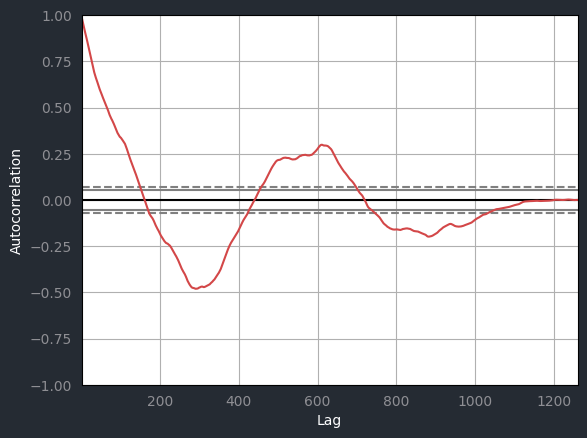

In [248]:
autocorrelation_plot(gsk_close_df, color=palette["red"])
# Modify plot elements
plt.gcf().patch.set_facecolor(palette["dark"])  # Background
plt.gca().xaxis.label.set_color(palette["light"])  # X-axis label
plt.gca().yaxis.label.set_color(palette["light"])  # Y-axis label
plt.gca().tick_params(colors=palette["stone"])  # Ticks
plt.gca().tick_params(axis="both", which="major", color=palette["dark"])  # Major tick lines
# Show the plot
plt.show()

The plot above shows that there is a strong correlation for the first 10-20 lag values.

We can select 10 for our AR value to incorporate recent values, without slowing down the model too much. Note that the original value of 0 suggested by auto_arima would suggest that the model ignores any recent price data.

### Model implementation

To keep predictions in line with current information, ARIMA can be run on a rolling basis by updating the list of past prices with each iteration.

In this case the predictions are for daily prices. The length of the test set is 252, which means the ARIMA model will run 252 times; each time it runs, the actual stock price for that time period (day) is added to the list of past prices, so that the next time ARIMA is run, it works on the basis of the most recent information.

In [252]:
past_prices = [x for x in X_train]
pred_prices = []
# Rolling validation
for t in range(len(X_test)):
    model = ARIMA(past_prices, order=(10,1,0))
    model_fit = model.fit()
    pred = model_fit.forecast()[0]
    pred_prices.append(pred)
    true_price = X_test[t]
    past_prices.append(true_price)
    if t % 15 == 0:
        print(f"{t:>3}/{len(X_test)}: Pred = {pred:,.2f}, True = {true_price[0]:,.2f}")

  0/252: Pred = 1,408.51, True = 1,410.80
 15/252: Pred = 1,476.05, True = 1,487.60
 30/252: Pred = 1,440.36, True = 1,439.40
 45/252: Pred = 1,404.37, True = 1,423.60
 60/252: Pred = 1,485.31, True = 1,485.80
 75/252: Pred = 1,467.62, True = 1,469.60
 90/252: Pred = 1,379.24, True = 1,391.40
105/252: Pred = 1,418.49, True = 1,402.20
120/252: Pred = 1,320.61, True = 1,332.60
135/252: Pred = 1,350.85, True = 1,365.00
150/252: Pred = 1,397.58, True = 1,397.60
165/252: Pred = 1,502.03, True = 1,534.40
180/252: Pred = 1,521.35, True = 1,519.20
195/252: Pred = 1,457.70, True = 1,423.00
210/252: Pred = 1,417.80, True = 1,411.20
225/252: Pred = 1,448.17, True = 1,455.80
240/252: Pred = 1,540.65, True = 1,549.00


In [276]:
rmse = root_mean_squared_error(X_test, pred_prices)
print(f"RMSE: {rmse:.2f}")
r2 = r2_score(X_test, pred_prices)
print(f"R2:    {r2:.2f}")

RMSE: 16.25
R2:    0.92


The root mean squared error (RMSE) value is in the same unit as the original data.

Therefore, an RMSE of 16.25 appears reasonable since the minimum and maximum Close values in the dataset are 1,199.56 and 1,859.88, respectively. At those values, 16.25 equates to errors of approximately 1.4% and 0.9%.

The r-squared (R2) value also performs strongly, accounting for 92% of the variance in Close price.

In [244]:
# Get true prices for each prediction
true_prices = [x[0] for x in past_prices[-Xt:]]

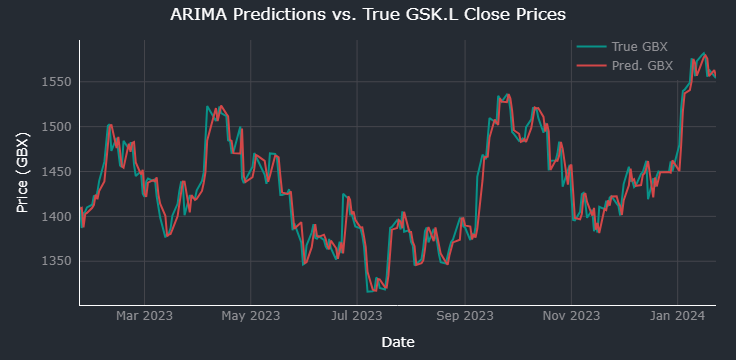

In [277]:
# Plot close prices
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=gsk_df["Date"].iloc[-Xt:], y=true_prices, 
    mode="lines", name="True GBX", line_color=palette["green"]))
fig.add_trace(go.Scatter(
    x=gsk_df["Date"].iloc[-Xt:], y=pred_prices, 
    mode="lines", name="Pred. GBX", line_color=palette["red"]))
# Update layout with date formatting
fig.update_layout(
    title="ARIMA Predictions vs. True GSK.L Close Prices",
    xaxis_title="Date",
    yaxis_title="Price (GBX)",
    xaxis_type="date",
    legend=dict(x=0.773, y=1.03)
)
# Set label formats for hovering
fig.update_traces(
    hovertemplate="%{x:%b %d, %Y}<br>Price: %{y:,.2f}<extra></extra>" # extra code removes trace name default
)
# Show plot
format_plot(fig)
fig.show()

## TBIL - cyclical ETF

TBIL is the stock ticker for the [US Treasury 3 Month Bill ETF](https://finance.yahoo.com/quote/TBIL), which has tracked the price of three-month Treasury Bills since the ETF launched in 2022.

The TBIL price has minor fluctuations within short cycles.

My assumption is that the cyclical nature of the TBIL price will make it easier for ARIMA forecast; since it has a different profile to GSK it will also be interesting to compare performance.

In [292]:
tbil_df = pd.read_csv("./data/20240124_TBIL_max.csv")

In [293]:
tbil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       366 non-null    object 
 1   Open       366 non-null    float64
 2   High       366 non-null    float64
 3   Low        366 non-null    float64
 4   Close      366 non-null    float64
 5   Adj Close  366 non-null    float64
 6   Volume     366 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 20.1+ KB


In [294]:
tbil_df.shape

(366, 7)

In [296]:
tbil_df.iloc[[0, -1]]

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-08-09,49.77,49.770000,49.764999,49.764999,46.824715,18100
365,2024-01-23,50.00,50.009998,50.000000,50.009998,50.009998,532800


In [297]:
tbil_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,366.000000,366.000000,366.000000,366.000000,366.000000,3.660000e+02
mean,49.944555,49.951609,49.931041,49.942814,48.241928,4.802981e+05
std,0.071629,0.070455,0.071912,0.071323,0.960140,3.946861e+05
min,49.770000,49.770000,49.764999,49.764999,46.824715,2.800000e+03
25%,49.895501,49.900002,49.880001,49.889999,47.370919,1.228250e+05
50%,49.937500,49.950001,49.919998,49.932501,48.172846,3.983500e+05
75%,50.000000,50.000000,49.990002,50.000000,49.072338,7.188750e+05
max,50.099998,50.099998,50.080002,50.099998,50.009998,2.073900e+06


In [298]:
tbil_df[tbil_df.isnull().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume


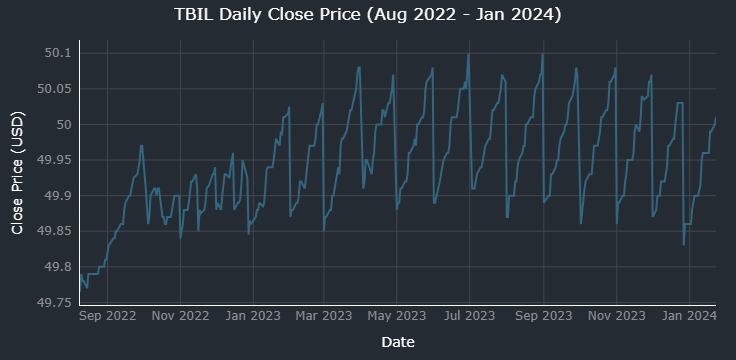

In [299]:
fig = go.Figure()
# Plot close prices
fig.add_trace(go.Scatter(x=tbil_df["Date"], y=tbil_df["Close"], mode="lines", name="Close Price (USD)"))
# Update layout
fig.update_layout(title="TBIL Daily Close Price (Aug 2022 - Jan 2024)",
                  xaxis_title="Date",
                  yaxis_title="Close Price (USD)"
)
# Set label formats for hovering on data points
fig.update_traces(
    hovertemplate="%{x:%Y/%M/%D}<br>GBX: %{y:,.2f}<extra></extra>",  # extra code removes trace name default
    line_color=palette["blue"]
)
# Show plot
format_plot(fig)
fig.show()

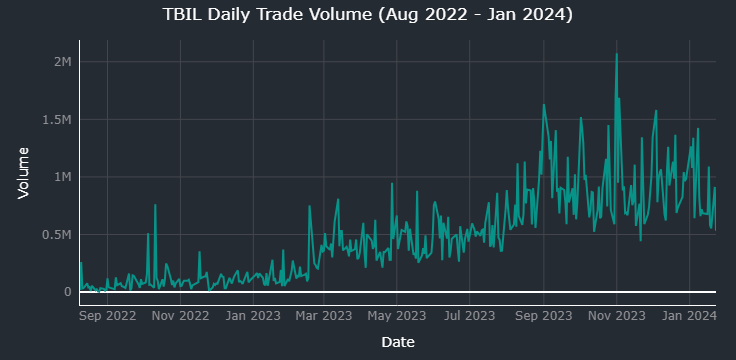

In [300]:
fig = go.Figure()
# Plot close prices
fig.add_trace(go.Scatter(x=tbil_df["Date"], y=tbil_df["Volume"], mode="lines", name="Volume"))
# Update layout
fig.update_layout(title="TBIL Daily Trade Volume (Aug 2022 - Jan 2024)",
                  xaxis_title="Date",
                  yaxis_title="Volume"
)
# Set label formats for hovering on data points
fig.update_traces(
    hovertemplate="%{x:%Y/%M/%D}<br>%{y:,}<extra></extra>",  # <extra> code removes trace name default
    line_color=palette["green"]
)
# Show plot
format_plot(fig)
fig.show()

### Prepare data for training

In [301]:
tbil_close_df = tbil_df[["Date", "Close"]].copy()

In [302]:
tbil_close_df.set_index("Date", inplace=True)

In [303]:
# Convert Date index to datetime with daily frequency
tbil_close_df.index = pd.DatetimeIndex(tbil_close_df.index).to_period("D")

In [304]:
# Train-Test Split
X = tbil_close_df.values
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]

In [305]:
X_train.shape

(292, 1)

In [306]:
X_test.shape

(74, 1)

In [307]:
Xt = len(X_test)

### Hyperparameter tuning

As before, we can tune the (p,d,q) values, using auto_arima and the autocorrelation plot from Pandas as guides.

This time, auto_arima's "seasonal" parameter is set to True due to the cyclical nature of the ETF.

In [308]:
# Use pdarima.arima.auto_arima to find optimal (p,d,q)
model_v2 = auto_arima(gsk_close_df["Close"], seasonal=True, trace=True)
print(model_v2.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11234.517, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11232.219, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11231.651, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11231.496, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11230.232, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11232.917, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.701 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1260
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5614.116
Date:                Thu, 25 Jan 2024   AIC                          11230.232
Time:                        00:30:09   BIC                          11235.370
Sample:                    01-24-2019   HQIC                         11232.163
    

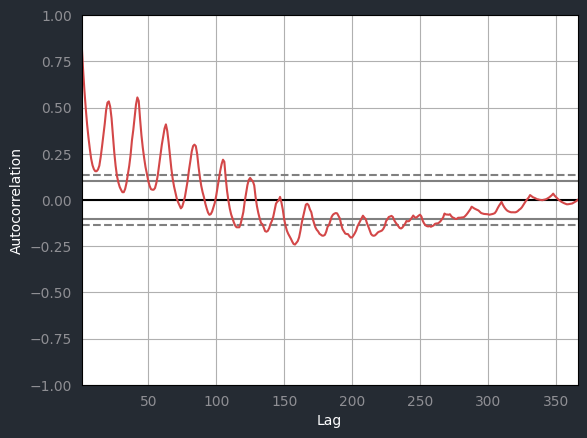

In [309]:
autocorrelation_plot(tbil_close_df, color=palette["red"])
# Modify plot elements
plt.gcf().patch.set_facecolor(palette["dark"])  # Background
plt.gca().xaxis.label.set_color(palette["light"])  # X-axis label
plt.gca().yaxis.label.set_color(palette["light"])  # Y-axis label
plt.gca().tick_params(colors=palette["stone"])  # Ticks
plt.gca().tick_params(axis="both", which="major", color=palette["dark"])  # Major tick lines
# Show the plot
plt.show()

The autocorrelation plot above has a notably different profile to the GSK plot, a probable result of the ETF's price cycles.

### Model implementation

In [310]:
past_prices = [x for x in X_train]
pred_prices = []
# Rolling validation
for t in range(len(X_test)):
    model = ARIMA(past_prices, order=(0,1,0))
    model_fit = model.fit()
    pred = model_fit.forecast()[0]
    pred_prices.append(pred)
    true_price = X_test[t]
    past_prices.append(true_price)
    if t % 15 == 0:
        print(f"{t:>3}/{len(X_test)}: Pred = {pred:,.2f}, True = {true_price[0]:,.2f}")

  0/74: Pred = 49.91, True = 49.92
 15/74: Pred = 50.06, True = 50.06
 30/74: Pred = 49.99, True = 50.00
 45/74: Pred = 49.92, True = 49.92
 60/74: Pred = 49.86, True = 49.88


In [311]:
rmse = root_mean_squared_error(X_test, pred_prices)
print(f"RMSE: {rmse:.2f}")
r2 = r2_score(X_test, pred_prices)
print(f"R2:    {r2:.2f}")

RMSE: 0.04
R2:    0.48


ARIMA appears to have adapted well to the cycles in the data, with a very low RMSE of just US$0.04.

The R2 of just 0.48 indicates that the model has poor explanatory power regarding the variance in price. This is perhaps to be expected, since the cycles are a factor of external policies (routine dividends) that result in sharp shift in trading behaviour. To better account for this, other variables would need to be worked into the model.

In [312]:
# Get true prices for each prediction
true_prices = [x[0] for x in past_prices[-Xt:]]

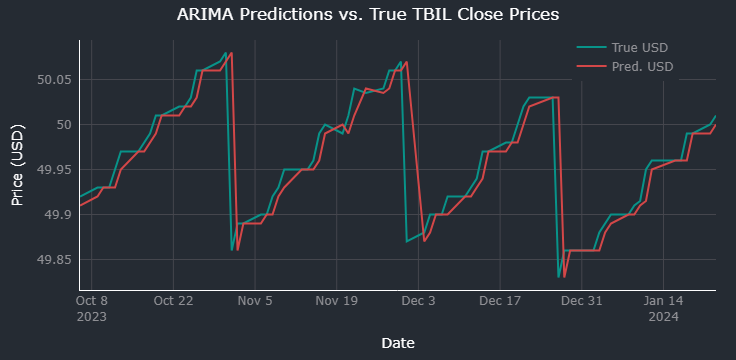

In [313]:
# Plot close prices
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=tbil_df["Date"].iloc[-Xt:], y=true_prices, 
    mode="lines", name="True USD", line_color=palette["green"]))
fig.add_trace(go.Scatter(
    x=tbil_df["Date"].iloc[-Xt:], y=pred_prices, 
    mode="lines", name="Pred. USD", line_color=palette["red"]))
# Update layout with date formatting
fig.update_layout(
    title="ARIMA Predictions vs. True TBIL Close Prices",
    xaxis_title="Date",
    yaxis_title="Price (USD)",
    xaxis_type="date",
    legend=dict(x=0.773, y=1.03)
)
# Set label formats for hovering
fig.update_traces(
    hovertemplate="%{x:%b %d, %Y}<br>Price: %{y:,.2f}<extra></extra>" # extra code removes trace name default
)
# Show plot
format_plot(fig)
fig.show()